# Explore here

In [ ]:
# Your code here

# my installation commands
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sqlalchemy import create_engine, text
import streamlit as st
from dotenv import load_dotenv
import os
import joblib
import shap

In [2]:
#I ran into some issues organizing the folders, so with this, I'm asking Python to always start from the project root.

import os
os.chdir("/workspaces/Volnuratus-Non-Victus")

In [3]:
#Loading the files with clean relative paths now.

ddos_df = pd.read_csv("data/raw/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)
portscan_df = pd.read_csv("data/raw/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory=False)
wednesday_df = pd.read_csv("data/raw/Wednesday-workingHours.pcap_ISCX.csv", low_memory=False)


In [4]:
#Inspecting each dataframe.

# Check shape
print("DDoS:", ddos_df.shape)
print("PortScan:", portscan_df.shape)
print("Wednesday:", wednesday_df.shape)

# Check column names
print(ddos_df.columns.tolist())

# Preview the first few rows
ddos_df.head()


DDoS: (225745, 79)
PortScan: (286467, 79)
Wednesday: (692703, 79)
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' 

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
#I'm removing leading/trailing spaces

ddos_df.columns = ddos_df.columns.str.strip()
portscan_df.columns = portscan_df.columns.str.strip()
wednesday_df.columns = wednesday_df.columns.str.strip()


In [6]:
#Adding source labels to track origin during merges.

ddos_df["Source"] = "DDoS"
portscan_df["Source"] = "PortScan"
wednesday_df["Source"] = "Wednesday"


In [7]:
#Merging

combined_df = pd.concat([ddos_df, portscan_df, wednesday_df], ignore_index=True)
print("Combined shape:", combined_df.shape)


Combined shape: (1204915, 80)


In [8]:
#I'm inspecting my labels, counting how many "Benign" rows vs attact types. (DDoS, PortScan, etc.)

combined_df["Label"].value_counts()


Label
BENIGN              665286
DoS Hulk            231073
PortScan            158930
DDoS                128027
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

In [9]:
#previewing column types

combined_df.dtypes.value_counts()


int64      54
float64    24
object      2
Name: count, dtype: int64

In [10]:
#picking a categorical feature
combined_df.select_dtypes(include="object").columns.tolist()


['Label', 'Source']

In [11]:
#Listin the first 30 column names to pick from

combined_df.columns[:30].tolist()


['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min']

In [12]:
#I'm subsetting the data after selecting 20 predictors.

selected_columns = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
    'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd IAT Max', 'Source', 'Label'
]

df = combined_df[selected_columns].copy()
print("Subset shape:", df.shape)
df.head()


Subset shape: (1204915, 21)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Fwd IAT Mean,Bwd IAT Mean,Fwd IAT Max,Source,Label
0,54865,3,2,0,12,0,6,6.0,0.0,0,...,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,0.0,3,DDoS,BENIGN
1,55054,109,1,1,6,6,6,6.0,0.0,6,...,0.0,1.100917e+05,18348.62385,109.0,0.0,0.0,0.0,0,DDoS,BENIGN
2,55055,52,1,1,6,6,6,6.0,0.0,6,...,0.0,2.307692e+05,38461.53846,52.0,0.0,0.0,0.0,0,DDoS,BENIGN
3,46236,34,1,1,6,6,6,6.0,0.0,6,...,0.0,3.529412e+05,58823.52941,34.0,0.0,0.0,0.0,0,DDoS,BENIGN
4,54863,3,2,0,12,0,6,6.0,0.0,0,...,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,0.0,3,DDoS,BENIGN


In [13]:
#Handling missing values - this will show us the top 10 columns with the most missing values

df.isnull().sum().sort_values(ascending=False).head(10)


Flow Bytes/s                   1027
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Destination Port                  0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Mean            0
Fwd Packet Length Max             0
Fwd Packet Length Std             0
dtype: int64

In [16]:
#I chose to fill it with the median since it is a numeric column with low missingness

In [14]:
#I'm now filling the missing values in the "Flow bytes" column

df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].median(), inplace=True)

#Trying my distribution to be stable and avoid skewing

/tmp/ipykernel_571/1215113440.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].median(), inplace=True)


In [15]:
#One-hot encoding to convert my categorical column ('source') into binary flags

df = pd.get_dummies(df, columns=["Source"], drop_first=True)

#this will also drop 'Source_DDoS' to avoid multicollinearity

In [16]:

print("Final shape:", df.shape)
print(df.dtypes.value_counts())


Final shape: (1204915, 22)
float64    10
int64       9
bool        2
object      1
Name: count, dtype: int64


In [17]:
#I'm encoding my target variable so it's ready for modeling and database storage

df["Label"] = df["Label"].astype("category")
df["Label_encoded"] = df["Label"].cat.codes


In [18]:
#a small optional dictionary that helps to interpret predictions later

label_mapping = dict(enumerate(df["Label"].cat.categories))


In [19]:
#I'm now establishing a SQLite database and saving the table

import sqlite3

# Create connection (or open existing)
conn = sqlite3.connect("data/processed/cicids_cleaned.db")

# Save DataFrame to SQLite in manageable chunks
df.to_sql("network_traffic", conn, index=False, if_exists="replace", chunksize=10000)

# Close connection
conn.close()



In [20]:
#Running SQL queries now

conn = sqlite3.connect("data/processed/cicids_cleaned.db")

# Example: count rows per label
query = "SELECT Label, COUNT(*) as count FROM network_traffic GROUP BY Label"
pd.read_sql(query, conn)


,Label,count
0,BENIGN,665286
1,DDoS,128027
2,DoS GoldenEye,10293
3,DoS Hulk,231073
4,DoS Slowhttptest,5499
5,DoS slowloris,5796
6,Heartbleed,11
7,PortScan,158930


In [21]:
#Doing descriptive analysis via SQL

#Average flow duration per label - this shows us which types of attacks tend to last longer

avg_flow_duration_query = """
SELECT Label, AVG("Flow Duration") AS avg_duration
FROM network_traffic
GROUP BY Label
ORDER BY avg_duration DESC
"""
pd.read_sql(avg_flow_duration_query, conn)

,Label,avg_duration
0,Heartbleed,1.106797e+08
1,DoS Slowhttptest,5.771989e+07
2,DoS Hulk,5.708173e+07
3,DoS slowloris,5.655437e+07
4,DoS GoldenEye,2.312722e+07
5,DDoS,1.695559e+07
6,BENIGN,1.254480e+07
7,PortScan,8.282023e+04


In [22]:
#Flow Bytes/s Summary per label - shows outliers and compare traffic intensity across labels

flow_bytes_summary_query = """
SELECT Label,
       AVG("Flow Bytes/s") AS avg_bytes,
       MIN("Flow Bytes/s") AS min_bytes,
       MAX("Flow Bytes/s") AS max_bytes,
       COUNT(*) AS count
FROM network_traffic
GROUP BY Label
ORDER BY avg_bytes DESC
"""
pd.read_sql(flow_bytes_summary_query, conn)

,Label,avg_bytes,min_bytes,max_bytes,count
0,PortScan,inf,0.000000e+00,inf,158930
1,DDoS,inf,2.212181e-01,inf,128027
2,BENIGN,inf,-1.930000e+08,inf,665286
3,DoS Slowhttptest,2.164242e+07,0.000000e+00,1.980000e+09,5499
4,Heartbleed,6.590280e+04,6.341193e+04,6.651081e+04,11
5,DoS slowloris,4.392122e+04,0.000000e+00,6.155172e+06,5796
6,DoS Hulk,2.929546e+04,0.000000e+00,1.260000e+07,231073
7,DoS GoldenEye,6.882391e+02,0.000000e+00,3.662726e+03,10293


In [23]:

#Top 5 most common destination ports - will help me to reveal which ports are often used or targeted

top_ports_query = """
SELECT "Destination Port", COUNT(*) AS count
FROM network_traffic
GROUP BY "Destination Port"
ORDER BY count DESC
LIMIT 5
"""
pd.read_sql(top_ports_query, conn)

,Destination Port,count
0,80,455114
1,53,286225
2,443,140649
3,123,5277
4,22,3426


<Axes: title={'center': 'Label Distribution'}, xlabel='Label'>

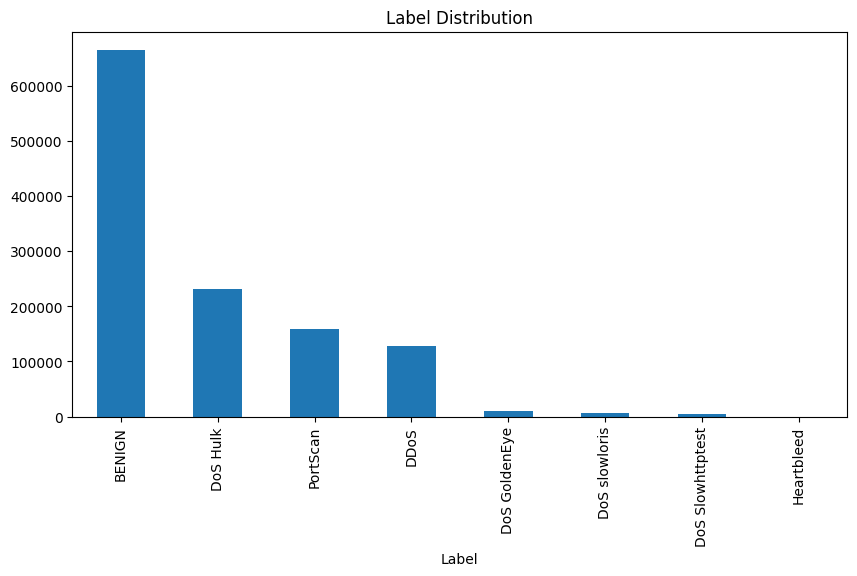

In [24]:
#EDA
df["Label"].value_counts().plot(kind="bar", figsize=(10,5), title="Label Distribution")


In [25]:
#Before moving deeper in my EDA - I'm checking how many rows contain missing values

df.isnull().sum().sum()

#Since the amount of missing values is low out of over 1.2 million rows, I think it's better to drop them.

np.int64(0)

In [26]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaNs
df_cleaned = df.dropna()


In [27]:

df_cleaned["Flow Bytes/s_log"] = np.log1p(df_cleaned["Flow Bytes/s"])
df_cleaned["Flow Duration_log"] = np.log1p(df_cleaned["Flow Duration"])
df_cleaned["Flow Packets/s_log"] = np.log1p(df_cleaned["Flow Packets/s"])


/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_571/1177422858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Flow Bytes/s_log"] = np.log1p(df_cleaned["Flow Bytes/s"])
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_571/1177422858.py:2: SettingWithCopyWar

<Axes: >

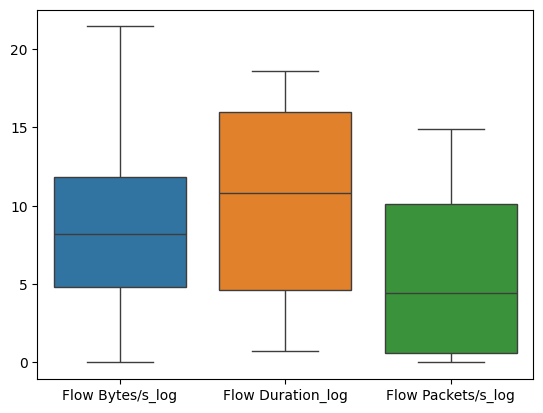

In [28]:
#Box plot

sns.boxplot(data=df_cleaned[["Flow Bytes/s_log", "Flow Duration_log", "Flow Packets/s_log"]])


In [29]:


df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    "Flow Bytes/s_log", "Flow Duration_log", "Flow Packets/s_log"
])


array([[<Axes: title={'center': 'Flow Bytes/s_log'}>,
        <Axes: title={'center': 'Flow Duration_log'}>],
       [<Axes: title={'center': 'Flow Packets/s_log'}>, <Axes: >]],
      dtype=object)

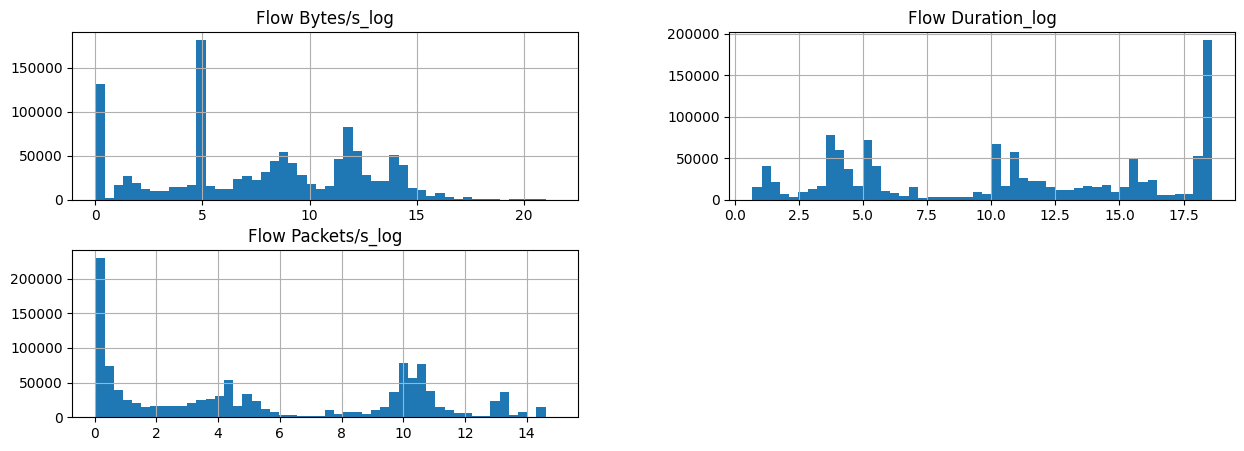

In [30]:
#Histogram

df_cleaned[["Flow Bytes/s_log", "Flow Duration_log", "Flow Packets/s_log"]].hist(figsize=(15, 5), bins=50)


In [31]:
#dropping redundant versions

df_cleaned.drop(columns=["Flow Bytes/s", "Flow Duration", "Flow Packets/s"], inplace=True)


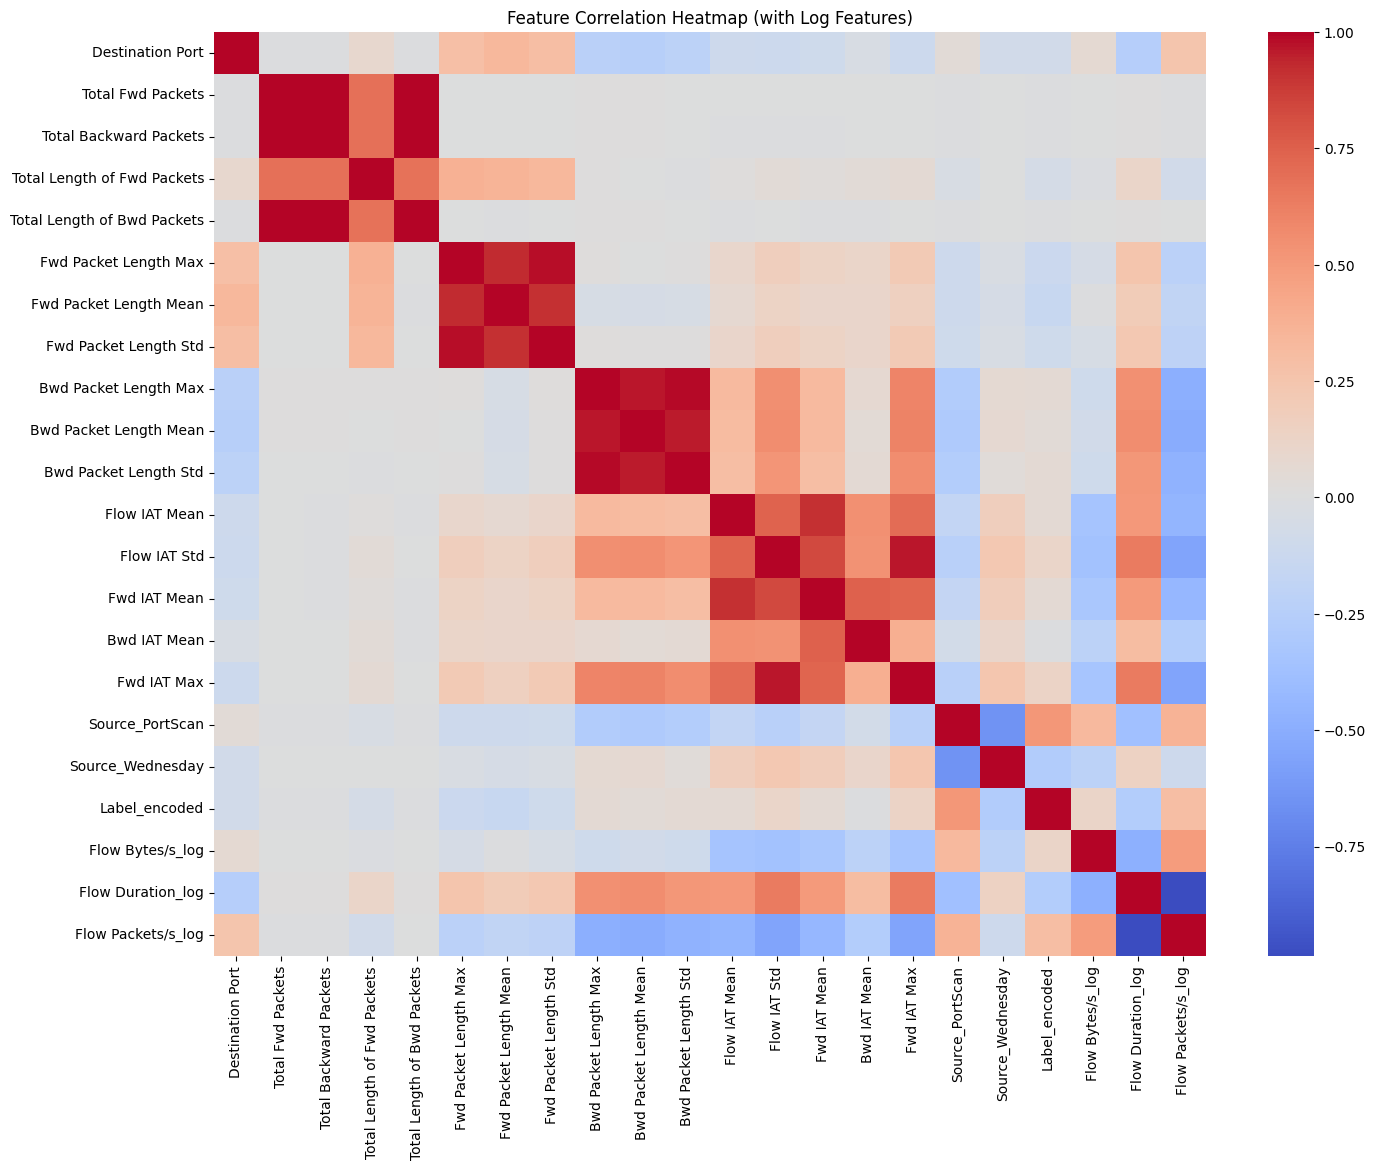

In [32]:
#heatmap

plt.figure(figsize=(16,12))
sns.heatmap(df_cleaned.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (with Log Features)")
plt.show()


In [33]:
#I was struggling a little bit interpreting the heat-map and the correlation, so I extracted the correlation directly.

# Step 1: Get correlation matrix
corr_matrix = df_cleaned.corr(numeric_only=True)

# Step 2: Extract correlations with Label_encoded
label_corr = corr_matrix["Label_encoded"].sort_values(ascending=False)

# Step 3: Display as a clean table
print("Correlation with Label_encoded:\n")
print(label_corr)


Correlation with Label_encoded:

Label_encoded                  1.000000
Source_PortScan                0.517348
Flow Packets/s_log             0.297314
Fwd IAT Max                    0.123862
Flow Bytes/s_log               0.116277
Flow IAT Std                   0.109256
Bwd Packet Length Std          0.058513
Fwd IAT Mean                   0.058014
Bwd Packet Length Max          0.055807
Flow IAT Mean                  0.055108
Bwd Packet Length Mean         0.044464
Total Length of Bwd Packets   -0.003290
Total Backward Packets        -0.004844
Total Fwd Packets             -0.005214
Bwd IAT Mean                  -0.006168
Total Length of Fwd Packets   -0.059879
Destination Port              -0.084397
Fwd Packet Length Std         -0.101329
Fwd Packet Length Max         -0.120188
Fwd Packet Length Mean        -0.140206
Flow Duration_log             -0.268196
Source_Wednesday              -0.272054
Name: Label_encoded, dtype: float64


In [34]:
#feature selection and model prep

# Define features and target
features = ["Source_PortScan", "Flow Packets/s_log", "Flow Duration_log", "Source_Wednesday", "Flow Bytes/s_log"]
X = df_cleaned[features]
y = df_cleaned["Label_encoded"]


In [35]:
#Train/Split test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
import pandas as pd

# Save test features and labels to CSV for Streamlit
X_test.to_csv("data/X_test.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

# (Optional) Save training sets too, if you want them later
X_train.to_csv("data/X_train.csv", index=False)
y_train.to_csv("data/y_train.csv", index=False)


In [37]:
#Trying to scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#Trying first with logistic regression

# Train on scaled data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_scaled = logreg.predict(X_test_scaled)

print("Confusion Matrix (Scaled):\n", confusion_matrix(y_test, y_pred_scaled))
print("\nClassification Report (Scaled):\n", classification_report(y_test, y_pred_scaled))


Confusion Matrix (Scaled):
 [[104015  10517    110  15140      0      0      0   3138]
 [  1950  23655      0      0      0      0      0      0]
 [  1552      0      0    507      0      0      0      0]
 [  7350      0      0  38675      0      0      0      0]
 [   161      0     51    888      0      0      0      0]
 [   535      0      0    624      0      0      0      0]
 [     0      0      0      2      0      0      0      0]
 [   387      0      0      0      0      0      0  31374]]

Classification Report (Scaled):
               precision    recall  f1-score   support

           0       0.90      0.78      0.84    132920
           1       0.69      0.92      0.79     25605
           2       0.00      0.00      0.00      2059
           3       0.69      0.84      0.76     46025
           4       0.00      0.00      0.00      1100
           5       0.00      0.00      0.00      1159
           6       0.00      0.00      0.00         2
           7       0.91      0.9

/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [39]:
# Parameter distributions
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

# Take a 20% sample of training data for tuning
X_small = X_train.sample(frac=0.2, random_state=42)
y_small = y_train.loc[X_small.index]

# Randomized search on the smaller set
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=3,   # fewer combos
    cv=2,       # lighter cross-validation
    scoring='accuracy',
    n_jobs=1,
    random_state=42
)

random_search.fit(X_small, y_small)
print("Best Parameters:", random_search.best_params_)

# Retrain final model on full dataset with best params
rf_final = RandomForestClassifier(
    **random_search.best_params_,
    random_state=42,
    class_weight='balanced'
)

rf_final.fit(X_train, y_train)
y_pred_final = rf_final.predict(X_test)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 20}


[Before prediction] Memory used: 2917.98 MB
[After prediction] Memory used: 2917.98 MB
Confusion Matrix:
 [[127201   2787    121   2580     81     18      0    132]
 [   147  25458      0      0      0      0      0      0]
 [    32      0   2023      3      0      1      0      0]
 [   314      0     11  45699      1      0      0      0]
 [    35      0      0      0   1061      4      0      0]
 [    37      0      0      0      3   1119      0      0]
 [     1      0      0      0      0      0      1      0]
 [    26      0      0      0      0      0      0  31735]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    132920
           1       0.90      0.99      0.95     25605
           2       0.94      0.98      0.96      2059
           3       0.95      0.99      0.97     46025
           4       0.93      0.96      0.94      1100
           5       0.98      0.97      0.97      1159
           6     

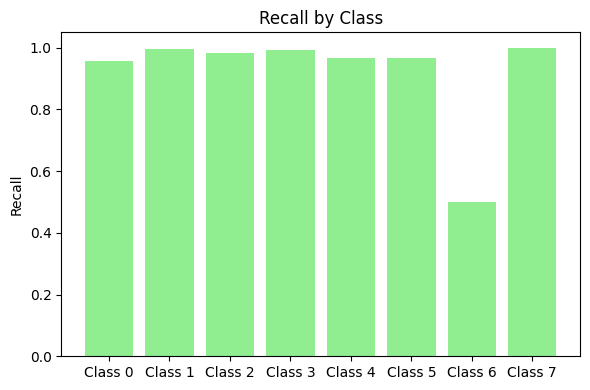

[After recall chart] Memory used: 2917.98 MB


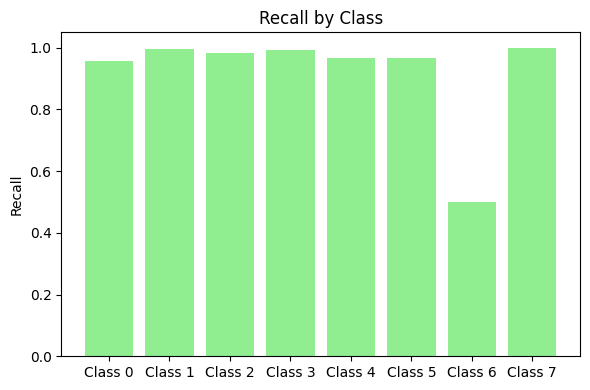

[After recall chart] Memory used: 2917.98 MB
[Before feature importance] Memory used: 2917.98 MB


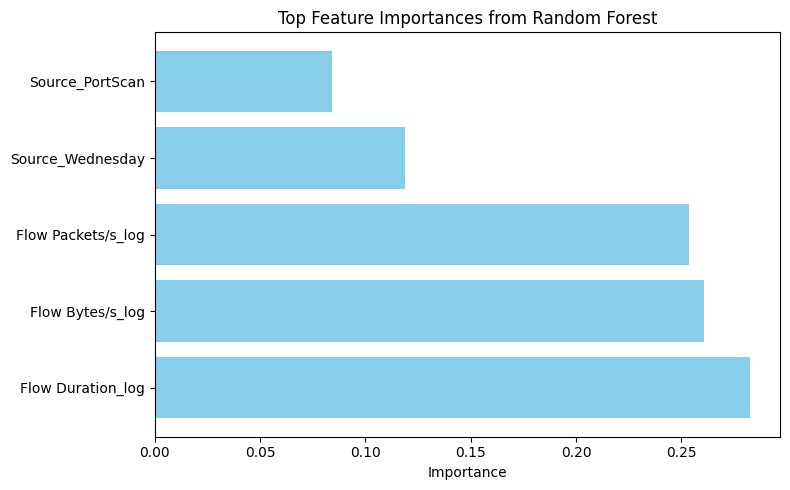

[After feature importance] Memory used: 2917.98 MB


In [ ]:
import psutil, os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# Helper function to print memory usage
def check_memory(stage):
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024 ** 2
    print(f"[{stage}] Memory used: {mem:.2f} MB")

# Predictions
check_memory("Before prediction")
y_pred_final = rf_final.predict(X_test)
check_memory("After prediction")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_final, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_final, average='weighted'))

# Recall comparison chart (multiclass-safe)
check_memory("Before recall chart")

recalls = recall_score(y_test, y_pred_final, average=None)
labels = [f"Class {cls}" for cls in sorted(set(y_test))]

plt.figure(figsize=(6,4))
plt.bar(labels, recalls, color='lightgreen')
plt.ylabel("Recall")
plt.title("Recall by Class")
plt.tight_layout()
plt.show()

check_memory("After recall chart")


plt.figure(figsize=(6,4))
plt.bar(labels, recalls, color='lightgreen')
plt.ylabel("Recall")
plt.title("Recall by Class")
plt.tight_layout()
plt.show()
check_memory("After recall chart")

# Feature Importance (adaptive)
check_memory("Before feature importance")
importances = rf_final.feature_importances_
feature_names = X_train.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Limiting to top 20 if too many features
if len(feat_df) > 30:
    feat_df = feat_df.head(20)

plt.figure(figsize=(8,5))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Feature Importances from Random Forest')
plt.tight_layout()
plt.show()
check_memory("After feature importance")


In [ ]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf_final, "rf_model.pkl")

print("Model saved as rf_model.pkl")

# Later, when you want to load it back:
rf_loaded = joblib.load("rf_model.pkl")

# Verifying it's working by making a quick prediction
y_pred_loaded = rf_loaded.predict(X_test)
print("Loaded model predictions match:", (y_pred_loaded == y_pred_final).all())


Model saved as rf_model.pkl
Loaded model predictions match: True


In [42]:
print(X_train.columns.tolist())


['Source_PortScan', 'Flow Packets/s_log', 'Flow Duration_log', 'Source_Wednesday', 'Flow Bytes/s_log']


In [43]:
rf_final.predict([[1, 10.0, 20.0, 1, 50.0]])


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int8)

In [44]:
import numpy as np
print(np.bincount(y_train))


[531682 102420   8234 184099   4399   4637      9 127043]


In [49]:
rf_final.predict_proba([[1, 1000.0, 2000.0, 1, 5000.0]])


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.98017026, 0.        , 0.        , 0.        , 0.01982974,
        0.        , 0.        , 0.        ]])

In [45]:
X_test[y_test==1].head()
rf_final.predict(X_test[y_test==1].head())


array([1, 1, 1, 1, 1], dtype=int8)